# DAGMM outlier detection on KDD Cup '99 dataset

## Method

## Dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

In [1]:
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import sys
sys.path.append('..')
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer
from tqdm import tqdm

from odcd.datasets import fetch_kdd
from odcd.models.dagmm import DAGMM, relative_euclidean_distance
from odcd.utils.data import create_outlier_batch
from odcd.utils.saving import save_od, load_od
from odcd.utils.visualize import plot_instance_outlier, plot_feature_outlier_tabular

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [2]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [3]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [4]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

Apply standardization:

In [5]:
X_train = (X_train - mean) / stdev

## Test

In [6]:
x = X_train[0:5].astype('float32')
print(x.shape)

(5, 18)


In [9]:
enc = dagmm.encoder(x)
print(enc.shape)
print(enc)

(5, 1)
tf.Tensor(
[[-0.01708278]
 [ 0.00333866]
 [ 0.2742431 ]
 [-0.71791613]
 [-0.68309724]], shape=(5, 1), dtype=float32)


In [10]:
x_recon = dagmm.decoder(enc)
print(x_recon.shape)
print(x_recon)

(5, 18)
tf.Tensor(
[[-0.0118277   0.06388345  0.04720416 -0.25377864 -0.22058585  0.15174463
  -0.16812117  0.0878273  -0.06505597 -0.04391911 -0.02141622 -0.05162789
   0.05533678 -0.00924199  0.06202922  0.0212151  -0.15203704 -0.20424512]
 [-0.02315586  0.07938065  0.05531398 -0.24220848 -0.21619469  0.14484978
  -0.15104689  0.08060393 -0.04641144 -0.05592401 -0.02252934 -0.02808444
   0.05520929 -0.01553758  0.07287478  0.01808324 -0.14721934 -0.20415676]
 [-0.3158955   0.31857038  0.34245682 -0.31951648 -0.14510345 -0.37672162
   0.534951    0.3944642   0.33072415 -1.3267382  -1.2223785   0.9259163
   0.5050663   0.20241727  0.10522027  0.16160282 -0.09957361 -0.3331399 ]
 [ 0.25824246  0.07733788  0.10948197 -0.07508576 -0.05927583 -0.05199856
   0.1079787   0.41810817 -0.64930445 -0.26946148 -0.33302623  0.05099578
   0.19227153  0.26797336  0.13266347  0.06771885 -0.02191676 -0.0334738 ]
 [ 0.250213    0.06624924  0.1016228  -0.10759382 -0.09708869 -0.06029253
   0.10765229  0

In [11]:
def relative_euclidean_distance(x, y, axis = -1):
    dist = tf.norm(x - y, ord=2, axis=axis) / tf.norm(x, axis=axis)
    return dist

In [12]:
rec_cos = tf.reshape(tf.keras.losses.cosine_similarity(x, x_recon.numpy(), -1), (-1, 1))
print(rec_cos.shape)
print(rec_cos)
rec_euc =  tf.reshape(relative_euclidean_distance(x, x_recon, -1), (-1, 1))   
print(rec_euc.shape)
print(rec_euc)

(5, 1)
tf.Tensor(
[[-0.28316206]
 [-0.30144957]
 [ 0.10801288]
 [ 0.8601516 ]
 [ 0.7589816 ]], shape=(5, 1), dtype=float32)
(5, 1)
tf.Tensor(
[[0.96170586]
 [0.9535194 ]
 [1.3321993 ]
 [1.5509527 ]
 [1.4915502 ]], shape=(5, 1), dtype=float32)


In [13]:
z = tf.concat([enc, rec_cos, rec_euc], -1) 
print(z.shape)
print(z)

(5, 3)
tf.Tensor(
[[-0.01708278 -0.28316206  0.96170586]
 [ 0.00333866 -0.30144957  0.9535194 ]
 [ 0.2742431   0.10801288  1.3321993 ]
 [-0.71791613  0.8601516   1.5509527 ]
 [-0.68309724  0.7589816   1.4915502 ]], shape=(5, 3), dtype=float32)


In [14]:
gamma = dagmm.gmm_density(z)
print(gamma.shape)
print(gamma)
print(gamma.numpy().sum(axis=1))

(5, 4)
tf.Tensor(
[[5.8677785e-12 7.7517047e-12 4.7774347e-03 9.9522263e-01]
 [4.3616326e-12 5.7200308e-12 3.6821300e-03 9.9631786e-01]
 [1.8559096e-13 2.9330068e-13 3.6461490e-06 9.9999630e-01]
 [4.8909720e-04 2.1616605e-03 4.5660507e-02 9.5168871e-01]
 [1.2101150e-04 4.7260884e-04 8.3103552e-02 9.1630286e-01]], shape=(5, 4), dtype=float32)
[1.0000001  1.         0.99999994 1.         1.        ]


In [15]:
N = gamma.shape[0]
print(N)
sum_gamma = tf.reduce_sum(gamma, 0)
print(sum_gamma.shape)
print(sum_gamma)
phi = sum_gamma / N
print(phi)
print(phi.numpy().sum())

5
(4,)
tf.Tensor([6.1010872e-04 2.6342692e-03 1.3722727e-01 4.8595281e+00], shape=(4,), dtype=float32)
tf.Tensor([1.22021745e-04 5.26853837e-04 2.74454542e-02 9.71905589e-01], shape=(4,), dtype=float32)
0.99999994


In [16]:
mu = (tf.reduce_sum(tf.expand_dims(gamma, -1) * tf.expand_dims(z, 1), 0)
              / tf.expand_dims(sum_gamma, -1))
print(mu.shape)
print(mu)

(4, 3)
tf.Tensor(
[[-0.71101     0.8400851   1.5391705 ]
 [-0.7116693   0.84200096  1.5402954 ]
 [-0.653052    0.72789216  1.4784287 ]
 [-0.21578008  0.2139955   1.2515721 ]], shape=(4, 3), dtype=float32)


In [17]:
z_mu = tf.expand_dims(z, 1) - tf.expand_dims(mu, 0)
print(z_mu.shape)
print(z_mu)

(5, 4, 3)
tf.Tensor(
[[[ 0.69392717 -1.1232471  -0.57746464]
  [ 0.6945865  -1.1251631  -0.5785895 ]
  [ 0.63596916 -1.0110543  -0.51672286]
  [ 0.1986973  -0.49715757 -0.28986627]]

 [[ 0.7143487  -1.1415347  -0.5856511 ]
  [ 0.715008   -1.1434505  -0.58677596]
  [ 0.65639067 -1.0293417  -0.5249093 ]
  [ 0.21911874 -0.51544505 -0.29805273]]

 [[ 0.9852531  -0.73207223 -0.20697117]
  [ 0.98591244 -0.73398805 -0.20809603]
  [ 0.9272951  -0.61987925 -0.14622939]
  [ 0.49002317 -0.10598262  0.0806272 ]]

 [[-0.00690615  0.0200665   0.01178217]
  [-0.00624681  0.01815063  0.01065731]
  [-0.06486416  0.13225943  0.07252395]
  [-0.50213605  0.6461561   0.29938054]]

 [[ 0.02791274 -0.0811035  -0.0476203 ]
  [ 0.02857208 -0.08301938 -0.04874516]
  [-0.03004527  0.03108943  0.01312149]
  [-0.46731716  0.54498607  0.23997808]]], shape=(5, 4, 3), dtype=float32)


In [18]:
z_mu_outer = tf.expand_dims(z_mu, -1) * tf.expand_dims(z_mu, -2)
print(z_mu_outer.shape)
print(z_mu_outer)

(5, 4, 3, 3)
tf.Tensor(
[[[[ 4.81534928e-01 -7.79451728e-01 -4.00718391e-01]
   [-7.79451728e-01  1.26168418e+00  6.48635507e-01]
   [-4.00718391e-01  6.48635507e-01  3.33465397e-01]]

  [[ 4.82450426e-01 -7.81523108e-01 -4.01880473e-01]
   [-7.81523108e-01  1.26599193e+00  6.51007533e-01]
   [-4.01880473e-01  6.51007533e-01  3.34765822e-01]]

  [[ 4.04456764e-01 -6.42999351e-01 -3.28619808e-01]
   [-6.42999351e-01  1.02223074e+00  5.22434831e-01]
   [-3.28619808e-01  5.22434831e-01  2.67002523e-01]]

  [[ 3.94806154e-02 -9.87838656e-02 -5.75956441e-02]
   [-9.87838656e-02  2.47165650e-01  1.44109204e-01]
   [-5.75956441e-02  1.44109204e-01  8.40224549e-02]]]


 [[[ 5.10294020e-01 -8.15453768e-01 -4.18359101e-01]
   [-8.15453768e-01  1.30310142e+00  6.68541074e-01]
   [-4.18359101e-01  6.68541074e-01  3.42987210e-01]]

  [[ 5.11236489e-01 -8.17576289e-01 -4.19549525e-01]
   [-8.17576289e-01  1.30747902e+00  6.70949280e-01]
   [-4.19549525e-01  6.70949280e-01  3.44306022e-01]]

  [[ 4.3

In [19]:
cov = (tf.reduce_sum(tf.expand_dims(tf.expand_dims(gamma, -1), -1) * z_mu_outer, 0)
               / tf.expand_dims(tf.expand_dims(sum_gamma, -1), -1))
print(cov.shape)
print(cov)

(4, 3, 3)
tf.Tensor(
[[[ 1.9277756e-04 -5.6012446e-04 -3.2887878e-04]
  [-5.6012446e-04  1.6274836e-03  9.5558347e-04]
  [-3.2887878e-04  9.5558347e-04  5.6107470e-04]]

 [[ 1.7848643e-04 -5.1860791e-04 -3.0450287e-04]
  [-5.1860791e-04  1.5068653e-03  8.8476291e-04]
  [-3.0450287e-04  8.8476291e-04  5.1949266e-04]]

 [[ 2.7610922e-02 -4.3950144e-02 -2.2493158e-02]
  [-4.3950144e-02  7.0433989e-02  3.6126930e-02]
  [-2.2493158e-02  3.6126930e-02  1.8543482e-02]]

 [[ 1.5789939e-01 -1.6563790e-01 -6.7641675e-02]
  [-1.6563790e-01  2.4517199e-01  1.2179766e-01]
  [-6.7641675e-02  1.2179766e-01  6.5170549e-02]]], shape=(4, 3, 3), dtype=float32)


In [20]:
np.diag(cov[0, :, :].numpy())  # diagonals >0 b/c variance

array([0.00019278, 0.00162748, 0.00056107], dtype=float32)

In [21]:
D = tf.shape(cov)[1]
print(D.numpy())

3


In [22]:
z_mu = tf.expand_dims(z, 1) - tf.expand_dims(mu, 0)
print(z_mu.shape)
print(z_mu)

(5, 4, 3)
tf.Tensor(
[[[ 0.69392717 -1.1232471  -0.57746464]
  [ 0.6945865  -1.1251631  -0.5785895 ]
  [ 0.63596916 -1.0110543  -0.51672286]
  [ 0.1986973  -0.49715757 -0.28986627]]

 [[ 0.7143487  -1.1415347  -0.5856511 ]
  [ 0.715008   -1.1434505  -0.58677596]
  [ 0.65639067 -1.0293417  -0.5249093 ]
  [ 0.21911874 -0.51544505 -0.29805273]]

 [[ 0.9852531  -0.73207223 -0.20697117]
  [ 0.98591244 -0.73398805 -0.20809603]
  [ 0.9272951  -0.61987925 -0.14622939]
  [ 0.49002317 -0.10598262  0.0806272 ]]

 [[-0.00690615  0.0200665   0.01178217]
  [-0.00624681  0.01815063  0.01065731]
  [-0.06486416  0.13225943  0.07252395]
  [-0.50213605  0.6461561   0.29938054]]

 [[ 0.02791274 -0.0811035  -0.0476203 ]
  [ 0.02857208 -0.08301938 -0.04874516]
  [-0.03004527  0.03108943  0.01312149]
  [-0.46731716  0.54498607  0.23997808]]], shape=(5, 4, 3), dtype=float32)


In [23]:
eps = 1e-6
L = tf.linalg.cholesky(cov + tf.eye(D) * eps)
print(L.shape)
print(L)

(4, 3, 3)
tf.Tensor(
[[[ 0.0139204   0.          0.        ]
  [-0.04023767  0.00306817  0.        ]
  [-0.02362567  0.0016106   0.00114385]]

 [[ 0.01339725  0.          0.        ]
  [-0.03871002  0.00306592  0.        ]
  [-0.02272875  0.00160882  0.00114375]]

 [[ 0.16616836  0.          0.        ]
  [-0.26449165  0.02188959  0.        ]
  [-0.13536365  0.01481873  0.00125234]]

 [[ 0.39736682  0.          0.        ]
  [-0.41683877  0.26724228  0.        ]
  [-0.17022477  0.19024451  0.0014495 ]]], shape=(4, 3, 3), dtype=float32)


In [24]:
log_det_cov = 2. * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)), 1)
print(log_det_cov.shape)
print(log_det_cov)

(4,)
tf.Tensor([-33.668858 -33.74712  -24.598484 -17.558056], shape=(4,), dtype=float32)


In [25]:
z_mu_T = tf.transpose(z_mu, perm=[1, 2, 0])
print(z_mu_T.shape)
print(z_mu_T)

(4, 3, 5)
tf.Tensor(
[[[ 0.69392717  0.7143487   0.9852531  -0.00690615  0.02791274]
  [-1.1232471  -1.1415347  -0.73207223  0.0200665  -0.0811035 ]
  [-0.57746464 -0.5856511  -0.20697117  0.01178217 -0.0476203 ]]

 [[ 0.6945865   0.715008    0.98591244 -0.00624681  0.02857208]
  [-1.1251631  -1.1434505  -0.73398805  0.01815063 -0.08301938]
  [-0.5785895  -0.58677596 -0.20809603  0.01065731 -0.04874516]]

 [[ 0.63596916  0.65639067  0.9272951  -0.06486416 -0.03004527]
  [-1.0110543  -1.0293417  -0.61987925  0.13225943  0.03108943]
  [-0.51672286 -0.5249093  -0.14622939  0.07252395  0.01312149]]

 [[ 0.1986973   0.21911874  0.49002317 -0.50213605 -0.46731716]
  [-0.49715757 -0.51544505 -0.10598262  0.6461561   0.54498607]
  [-0.28986627 -0.29805273  0.0806272   0.29938054  0.23997808]]], shape=(4, 3, 5), dtype=float32)


In [26]:
v = tf.linalg.triangular_solve(L, z_mu_T, lower=True)

In [27]:
logits = (tf.math.log(tf.expand_dims(phi, -1)) 
          - .5 * (tf.reduce_sum(tf.square(v), 1) 
                  + tf.cast(D, tf.float32) * tf.math.log(2. * np.pi) 
                  + tf.expand_dims(log_det_cov, -1)))
print(logits.shape)
print(logits.numpy())

(4, 5)
[[-4.9779965e+04 -5.4304395e+04 -2.8830978e+05  4.9426460e+00
   3.0463095e+00]
 [-4.9878715e+04 -5.4410359e+04 -2.8870378e+05  6.4588914e+00
   4.2822585e+00]
 [-1.4650102e+00 -2.2406983e+00 -1.0537365e+03  4.9916434e+00
   5.6381125e+00]
 [ 5.1370535e+00  5.0859332e+00  4.0667973e+00  4.9672480e+00
   5.1293707e+00]]


In [28]:
sample_energy = - tf.reduce_logsumexp(logits, axis=0)
print(sample_energy.shape)
print(sample_energy.numpy())

(5,)
[-5.13841   -5.086591  -4.0667973 -6.974762  -6.297632 ]


In [29]:
# if return_mean
sample_energy = tf.reduce_mean(sample_energy)
print(sample_energy.numpy())

-5.5128384


In [30]:
assert (tf.linalg.diag_part(cov).numpy() > 0).all()
cov_diag = tf.reduce_sum(tf.divide(1, tf.linalg.diag_part(cov)))
print(cov_diag.numpy())

15905.415


In [31]:
recon_error = tf.reduce_mean((x - x_recon) ** 2)
print(recon_error.shape)
print(recon_error.numpy())

()
0.38199684


In [32]:
w_energy = .1,
w_cov_diag = .005
loss = recon_error + w_energy * sample_energy + w_cov_diag * cov_diag
print(loss.numpy())

[79.35779]


In [33]:
tf.matmul(L,v).numpy() - z_mu_T.numpy()

array([[[ 0.0000000e+00, -5.9604645e-08,  0.0000000e+00,  0.0000000e+00,
         -1.8626451e-09],
        [ 0.0000000e+00,  0.0000000e+00,  1.1920929e-07,  0.0000000e+00,
          0.0000000e+00],
        [ 0.0000000e+00,  5.9604645e-08,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00]],

       [[-5.9604645e-08,  0.0000000e+00, -5.9604645e-08,  0.0000000e+00,
         -1.8626451e-09],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00]],

       [[ 1.4901161e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
    

In [34]:
v.shape

TensorShape([4, 3, 5])

In [ ]:
v**2

In [ ]:
v2 = tf.linalg.triangular_solve(L, z_mu, lower=True)

In [35]:
z_mu.shape

TensorShape([5, 4, 3])

In [36]:
z_mu_T.shape

TensorShape([4, 3, 5])

In [37]:
L.shape

TensorShape([4, 3, 3])

## Load or define outlier detector

In [39]:
filepath = './od_dagmm_kddcup_400/'
model_dir = filepath + 'model/'

encoder_net = tf.keras.models.load_model(model_dir + 'encoder_net.h5')
decoder_net = tf.keras.models.load_model(model_dir + 'decoder_net.h5')
gmm_density_net = tf.keras.models.load_model(model_dir + 'gmm_density_net.h5')
dagmm = DAGMM(encoder_net, decoder_net, gmm_density_net, 4, 1)
dagmm.load_weights(model_dir + 'dagmm.ckpt')

## Compute GMM parameters

`phi`, `mu` and `cov` are computed using the training data.

In [40]:
enc, x_recon, z, gamma = dagmm(X_train)
print('enc {} -- x_recon {} -- z {} -- gamma {}'.format(enc.shape, x_recon.shape,
                                                        z.shape, gamma.shape))
phi, mu, cov = dagmm.gmm_params(z, gamma)
print('phi {} -- mu {} -- cov {}'.format(phi.shape, mu.shape, cov.shape))

enc (400000, 1) -- x_recon (400000, 18) -- z (400000, 3) -- gamma (400000, 4)
phi (4,) -- mu (4, 3) -- cov (4, 3, 3)


In [41]:
print('phi:')
print(phi.numpy())
print('\nmu:')
print(mu.numpy())
print('\ncov:')
print(cov.numpy())

phi:
[3.4200554e-04 1.6416011e-03 1.2723717e-01 8.7193811e-01]

mu:
[[-2.565148    0.00443065  0.88143694]
 [-2.6043844  -0.01374791  0.8664328 ]
 [-2.0557203  -0.28866223  0.8015758 ]
 [-0.13816525 -0.07791626  1.0669043 ]]

cov:
[[[ 3.572538    1.8007861   1.378636  ]
  [ 1.8007861   0.9093518   0.69557333]
  [ 1.378636    0.69557333  0.53263277]]

 [[ 3.579228    1.8052233   1.3825364 ]
  [ 1.8052233   0.91226864  0.6982021 ]
  [ 1.3825364   0.6982021   0.5348184 ]]

 [[ 2.6425157   0.9033071   0.7245228 ]
  [ 0.9033071   0.4159162   0.2984627 ]
  [ 0.7245228   0.2984627   0.22520722]]

 [[ 0.11535199 -0.18426305 -0.09448788]
  [-0.18426305  0.2998673   0.15468629]
  [-0.09448788  0.15468629  0.07996181]]]


## Detect outliers

We now generate a batch of data with 10% outliers and detect the outliers in the batch. 

In [42]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [43]:
enc, x_recon, z, gamma = dagmm(X_outlier)
print('enc {} -- x_recon {} -- z {} -- gamma {}'.format(enc.shape, x_recon.shape,
                                                        z.shape, gamma.shape))

enc (1000, 1) -- x_recon (1000, 18) -- z (1000, 3) -- gamma (1000, 4)


In [ ]:
#phi, mu, cov = dagmm.gmm_params(z, gamma)
#print('phi {} -- mu {} -- cov {}'.format(phi.shape, mu.shape, cov.shape))

In [44]:
energies, cov_diag = dagmm.gmm_energy(z, phi, mu, cov, return_mean=False)
print('energies {}'.format(energies.shape))

energies (1000,)


## Display results

F1 score and confusion matrix:

In [45]:
threshold = 2.

F1 score: 0.7194244604316548


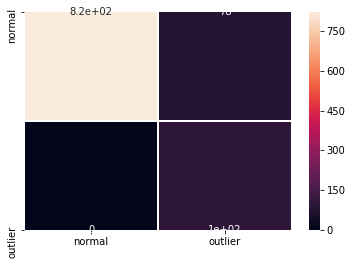

In [46]:
labels = outlier_batch.target_names
y_pred = energies > threshold
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

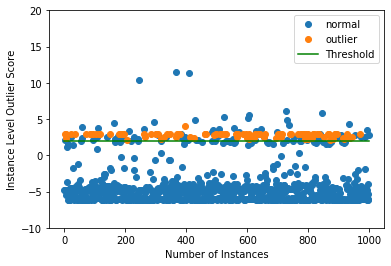

In [48]:
od_preds = {'data': {'instance_score': energies}}
plot_instance_outlier(od_preds, y_outlier, labels, threshold, ylim=(-10,20))

## Investigate results

Latent space values vs. cosine similarity and relative euclidean distance. **Outliers kind of grouped but not separated from normal data**.

In [49]:
z.shape

TensorShape([1000, 3])

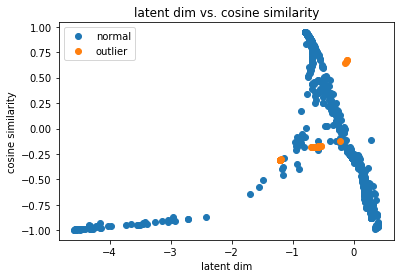

In [50]:
df = pd.DataFrame(dict(z=z[:, 0].numpy(), 
                       cos=z[:, 1].numpy(), 
                       label=y_outlier))
groups = df.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.z, group.cos, marker='o', 
            linestyle='', ms=6, label=labels[name])
plt.title('latent dim vs. cosine similarity')
plt.xlabel('latent dim')
plt.ylabel('cosine similarity')
ax.legend()
plt.show()

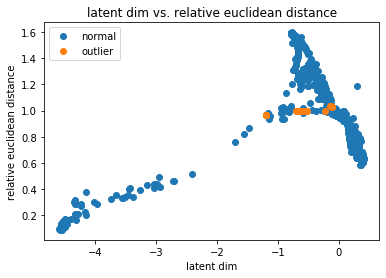

In [51]:
df = pd.DataFrame(dict(z=z[:, 0].numpy(), 
                       eucl=z[:, 2].numpy(), 
                       label=y_outlier))
groups = df.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.z, group.eucl, marker='o', 
            linestyle='', ms=6, label=labels[name])
plt.title('latent dim vs. relative euclidean distance')
plt.xlabel('latent dim')
plt.ylabel('relative euclidean distance')
#plt.xlim((-.3, 0.))
#plt.ylim((-.25, .25))
ax.legend()
plt.show()

Reconstructed instances:

In [52]:
idx = 0

NORMAL


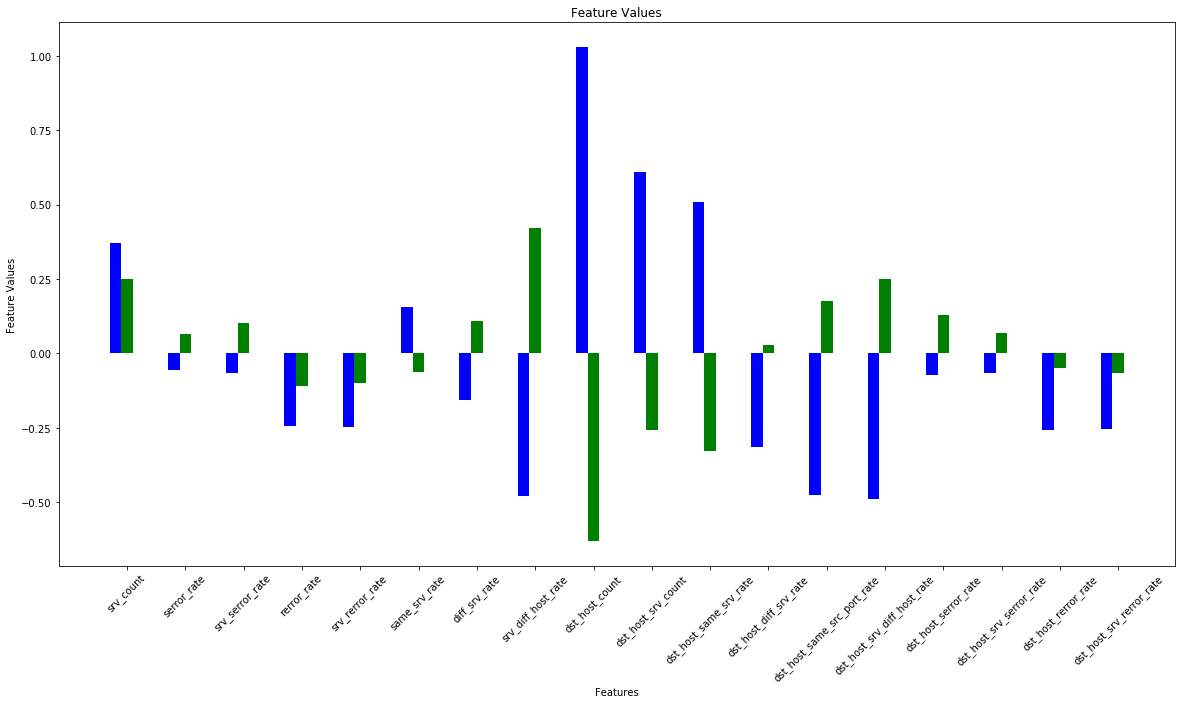

In [53]:
if y_outlier[idx] == 1:
    print('OUTLIER')
else:
    print('NORMAL')


width = .2
ticks = np.arange(X_outlier[idx].shape[0])
labels_values = ['Original', 'Reconstructed']

fig, ax = plt.subplots(figsize=(20,10))
plt.bar(ticks - width, X_outlier[idx], width=width, color='b', align='center')
plt.bar(ticks, x_recon[idx].numpy(), width=width, color='g', align='center')
plt.xticks(ticks=ticks, labels=kddcup.feature_names, rotation=45)
plt.title('Feature Values')
plt.xlabel('Features')
plt.ylabel('Feature Values')
plt.show()